# Target Variable: Military Compensation

In [23]:
import pandas as pd
usnational = pd.read_csv('usnational.csv')
# rename column to something readable
usnational = usnational.rename(columns={'observation_date': 'date',
                                        'B4080C1Q027SBEA': 'military_comp'})
# make sure 'date' is datetime
usnational['date'] = pd.to_datetime(usnational['date'])
# set index
usnational = usnational.set_index('date')
# Align usnational's index to quarter-end (so 1972-01-01 → 1972-03-31)
usnational_qe = usnational.copy()
usnational_qe.index = usnational_qe.index.to_period('Q').to_timestamp('Q')
usnational_qe = usnational_qe.iloc[84:]
usnational_qe.to_csv("Military_Compensation.csv", index=True)

# Geopolitical Factors

In [24]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# === 1. Load Geopolitical Risk Data ===
geo = pd.read_csv("geopolitical_risk.csv", sep=';')

# Parse date (confirmed format: month/day/year)
geo['date'] = pd.to_datetime(geo['date'], format='%m/%d/%y', errors='coerce')

# Replace commas with dots and convert to numeric
for col in geo.columns:
    if col != 'date':
        geo[col] = geo[col].astype(str).str.replace(',', '.').astype(float)

# Set date as index and sort
geo = geo.set_index('date').sort_index()

# Shift all geopolitical data one day back to match compensation timing (end of month)
geo.index = geo.index - pd.Timedelta(days=1)

# Resample to quarterly frequency (mean over each quarter)
geo_q = geo.resample('Q').mean()


# === 2. Load U.S. Compensation Data ===
comp = pd.read_csv("Military_Compensation.csv")

# Parse date column
if 'date' in comp.columns:
    comp['date'] = pd.to_datetime(comp['date'])
    comp = comp.set_index('date').sort_index()
else:
    comp.index = pd.to_datetime(comp.index)
    comp = comp.sort_index()


# === 3. Visualize the Date Structures ===

def structure_summary(df, name):
    """Show existing years, months, and days for each dataset."""
    df_dates = df.index.to_series()
    df_dates_df = pd.DataFrame({
        'year': df_dates.dt.year,
        'month': df_dates.dt.month,
        'day': df_dates.dt.day
    })
    grouped = (
        df_dates_df
        .groupby(['year', 'month'])['day']
        .apply(lambda x: sorted(x.unique()))
        .reset_index()
    )
    for _, row in grouped.iterrows():
        days_str = ', '.join(str(int(d)) for d in row['day'])

# Show both structures
structure_summary(comp, "U.S. Compensation")
structure_summary(geo_q, "Geopolitical Risk (Quarterly)")

# === 4. Align Start and End Dates ===

# Find overlapping date range
start_date = max(comp.index.min(), geo_q.index.min())
end_date   = min(comp.index.max(), geo_q.index.max())

# Trim both datasets to this common window
comp_aligned = comp.loc[start_date:end_date]
geo_aligned  = geo_q.loc[start_date:end_date]



# === 5. Verify index match ===

# Check if the two datasets have identical date indices
if comp_aligned.index.equals(geo_aligned.index):
    print("\n✅ Indices match perfectly. Both datasets aligned by date.")
else:
    print("\n⚠️ Index mismatch detected. Fixing...")

    # Align explicitly by intersection
    common_idx = comp_aligned.index.intersection(geo_aligned.index)
    comp_aligned = comp_aligned.loc[common_idx]
    geo_aligned = geo_aligned.loc[common_idx]

    # Confirm again
    if comp_aligned.index.equals(geo_aligned.index):
        print("✅ Fixed: indices now perfectly aligned.")
    else:
        print("❌ Still misaligned — investigate date frequency or timezone issues.")

# Optional sanity check
import matplotlib.pyplot as plt

# === 6. Validation Pipeline: Monthly vs Quarterly Aggregation ===

# Select a few representative columns to check
cols_to_check = ['geo_risk', 'geo_threats', 'geo_acts', 'geo_risk_china', 'geo_risk_russia', 'geo_risk_usa']

for col in cols_to_check:
    if col not in geo.columns:
        print(f"⚠️ Column '{col}' not found in monthly dataset, skipping...")
        continue

from sklearn.metrics import mean_absolute_error

# === 7. Numerical Validation: Correlation & Error Check ===


results = []

for col in cols_to_check:
    if col not in geo.columns:
        continue

    # Align monthly and quarterly values by date overlap
    q_index = geo_q.index
    m_to_q = geo[col].resample('Q').mean().reindex(q_index)

    # Drop NaN pairs for fair comparison
    valid = (~m_to_q.isna()) & (~geo_q[col].isna())
    x = m_to_q[valid]
    y = geo_q[col][valid]

    # Correlation and error metrics
    corr = x.corr(y)
    mae = mean_absolute_error(x, y)
    rel_err = (mae / y.mean()) * 100

    results.append({
        'column': col,
        'corr': round(corr, 4),
        'mae': round(mae, 4),
        'rel_err_%': round(rel_err, 2)
    })

# Present results as DataFrame
validation_df = pd.DataFrame(results)
# === 8. Merge Quarterly Geopolitical Data with Compensation ===

# Ensure both datasets are trimmed to the same date range again (for safety)
common_idx = comp_aligned.index.intersection(geo_aligned.index)
comp_final = comp_aligned.loc[common_idx]
geo_final = geo_aligned.loc[common_idx]

# Merge by date index
merged = pd.concat([comp_final, geo_final], axis=1)
# Quick sanity check

# Drop any rows with missing values for modeling
merged_clean = merged.dropna()
# Preview the data
geo_df = merged_clean
geo_df.to_csv("Geo_Factors.csv", index=True)



✅ Indices match perfectly. Both datasets aligned by date.


# Economic Variables

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For later, but import now
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# 1. LOAD BASE DATA
# -------------------------------

# 1.1 Military compensation (already quarterly)
comp = pd.read_csv(
    "Military_Compensation.csv",
    parse_dates=["date"],
    index_col="date"
).sort_index()

print("✅ comp loaded:", comp.shape)
print(comp.head(), "\n")

# 1.2 CPI (monthly, inflation column should be CPIAUCSL_PC1)
cpi = pd.read_csv(
    "CPI.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
).sort_index()

print("✅ cpi loaded:", cpi.shape)
print(cpi.head(), "\n")

# 1.3 ECI (quarterly)
eci = pd.read_csv(
    "Employment_Cost_Index.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
).sort_index()

print("✅ eci loaded:", eci.shape)
print(eci.head(), "\n")

# 1.4 GDP (quarterly)
gdp = pd.read_csv(
    "Real_GDP_Growth.csv",
    parse_dates=["observation_date"],
    index_col="observation_date"
).sort_index()

print("✅ gdp loaded:", gdp.shape)
print(gdp.head())
# -------------------------------
# 2. EXTEND ECI WITH MANUAL 1992–2000 DATA
# -------------------------------

# Your manually collected ECIALLCIV values:
# year, Q1, Q2, Q3, Q4
manual_eci_rows = [
    (1992, 63.0, 63.4, 64.0, 64.4),
    (1993, 65.2, 65.6, 66.3, 66.7),
    (1994, 67.3, 67.8, 68.4, 68.7),
    (1995, 69.3, 69.7, 70.3, 70.6),
    (1996, 71.2, 71.7, 72.3, 72.6),
    (1997, 73.3, 73.7, 74.4, 75.0),
    (1998, 75.6, 76.2, 77.1, 77.6),
    (1999, 77.9, 78.7, 79.5, 80.2),
    (2000, 81.3, 82.1, 83.0, 83.6),
]

manual_dates = []
manual_values = []

for year, q1, q2, q3, q4 in manual_eci_rows:
    # Quarter-end dates: Mar 31, Jun 30, Sep 30, Dec 31
    manual_dates += [
        pd.Timestamp(f"{year}-03-31"),
        pd.Timestamp(f"{year}-06-30"),
        pd.Timestamp(f"{year}-09-30"),
        pd.Timestamp(f"{year}-12-31"),
    ]
    manual_values += [q1, q2, q3, q4]

manual_eci = pd.DataFrame(
    {"ECIALLCIV": manual_values},
    index=pd.DatetimeIndex(manual_dates, name="observation_date")
).sort_index()

print("🔎 Manual ECI head:")
print(manual_eci.head(), "\n")
print("🔎 Manual ECI tail:")
print(manual_eci.tail(), "\n")

# Now align the original ECI to quarter-end as well
eci_q_orig = eci.copy()
eci_q_orig.index = eci_q_orig.index.to_period("Q").to_timestamp("Q")

print("🔎 Original ECI (after forcing quarter-end) head:")
print(eci_q_orig.head(), "\n")

# Combine manual + original, but let the *official* ECI overwrite any overlaps
eci_full = pd.concat([manual_eci, eci_q_orig])
eci_full = eci_full[~eci_full.index.duplicated(keep="last")]  # keep official where overlap
eci_full = eci_full.sort_index()

print("✅ Combined ECI range:", eci_full.index.min().date(), "→", eci_full.index.max().date())
print("Combined ECI sample:")
print(eci_full.loc["1992-03-31":"2002-12-31"].head(12))
# ---------------------------------------------
# 3. BUILD QUARTERLY MACRO SERIES USING eci_full
# ---------------------------------------------

# 3.1 CPI → quarterly inflation
cpi_q = (
    cpi.resample("Q").mean()
    .rename(columns={"CPIAUCSL_PC1": "inflation_rate"})
)

# 3.2 GDP → quarterly real GDP growth
gdp["gdp_growth"] = gdp["GDPC1"].pct_change() * 100
gdp_q = gdp[["gdp_growth"]].copy()
gdp_q.index = gdp_q.index.to_period("Q").to_timestamp("Q")

# 3.3 ECI → now from eci_full
eci_full = eci_full.copy()
eci_full["eci_growth"] = eci_full["ECIALLCIV"].pct_change() * 100

eci_q = eci_full[["eci_growth"]].copy()
# index already quarter-end

# ---------------------------------------------
# 4. MERGE MACRO COMPONENTS
# ---------------------------------------------

econ = pd.concat([gdp_q, eci_q, cpi_q], axis=1).sort_index()

print("Before trimming:")
print(econ.head(12), "\n")

# Drop rows where any of the 3 macro series is missing
econ = econ.dropna()

print("After dropna:")
print(econ.head(12), "\n")
print("Final econ range:", econ.index.min().date(), "→", econ.index.max().date())

# ---------------------------------------------
# 5. ALIGN WITH MILITARY COMPENSATION
# ---------------------------------------------
y_level_trimmed = comp.loc[econ.index.min():econ.index.max(), "military_comp"]

econ_df = pd.concat([y_level_trimmed, econ], axis=1)
econ_df = econ_df.iloc[3:]
print("Merged econ + compensation:")
print(econ_df.head(12))

# Save final dataset
econ_df.to_csv("Eco_Factors.csv")
print("📁 Saved → Eco_Factors.csv")

✅ comp loaded: (130, 1)
            military_comp
date                     
1993-03-31         76.610
1993-06-30         75.756
1993-09-30         74.416
1993-12-31         73.552
1994-03-31         73.021 

✅ cpi loaded: (933, 1)
                  CPIAUCSL_PC1
observation_date              
1948-01-01            10.24209
1948-02-01             9.48196
1948-03-01             6.81818
1948-04-01             8.27273
1948-05-01             9.38497 

✅ eci loaded: (98, 1)
                  ECIALLCIV
observation_date           
2001-01-01             84.7
2001-04-01             85.5
2001-07-01             86.4
2001-10-01             87.2
2002-01-01             87.9 

✅ gdp loaded: (314, 1)
                     GDPC1
observation_date          
1947-01-01        2182.681
1947-04-01        2176.892
1947-07-01        2172.432
1947-10-01        2206.452
1948-01-01        2239.682
🔎 Manual ECI head:
                  ECIALLCIV
observation_date           
1992-03-31             63.0
1992-06-30     

In [26]:
econ_df

,military_comp,gdp_growth,eci_growth,inflation_rate
1993-03-31,76.610,0.166944,1.242236,3.173320
1993-06-30,75.756,0.582171,0.613497,3.125143
1993-09-30,74.416,0.477155,1.067073,2.817297
1993-12-31,73.552,1.360149,0.603318,2.769267
1994-03-31,73.021,0.970363,0.899550,2.539493
...,...,...,...,...
2024-06-30,206.338,0.885486,0.915192,3.187670
2024-09-30,208.947,0.824778,0.846433,2.660637
2024-12-31,209.605,0.459875,0.899281,2.719313
2025-03-31,209.693,-0.162516,0.891266,2.739757


In [27]:
geo_df

,military_comp,geo_risk,geo_threats,geo_acts,geo_risk_china,geo_risk_russia,geo_risk_usa
date,,,,,,,
1993-03-31,76.610,103.480000,121.975000,76.500000,0.205000,0.990000,2.300000
1993-06-30,75.756,112.746667,131.536667,86.096667,0.263333,0.950000,2.466667
1993-09-30,74.416,97.523333,108.286667,78.963333,0.273333,0.673333,2.113333
1993-12-31,73.552,82.173333,98.430000,55.586667,0.233333,0.586667,1.780000
1994-03-31,73.021,102.023333,121.053333,74.873333,0.280000,0.860000,2.276667
...,...,...,...,...,...,...,...
2024-06-30,206.338,111.930000,117.440000,112.526667,0.853333,1.393333,2.630000
2024-09-30,208.947,133.863333,128.963333,147.710000,0.796667,1.453333,3.070000
2024-12-31,209.605,127.646667,127.356667,133.873333,0.893333,1.793333,3.056667


In [28]:
usnational_qe

,military_comp
date,
1993-03-31,76.610
1993-06-30,75.756
1993-09-30,74.416
1993-12-31,73.552
1994-03-31,73.021
...,...
2024-06-30,206.338
2024-09-30,208.947
2024-12-31,209.605


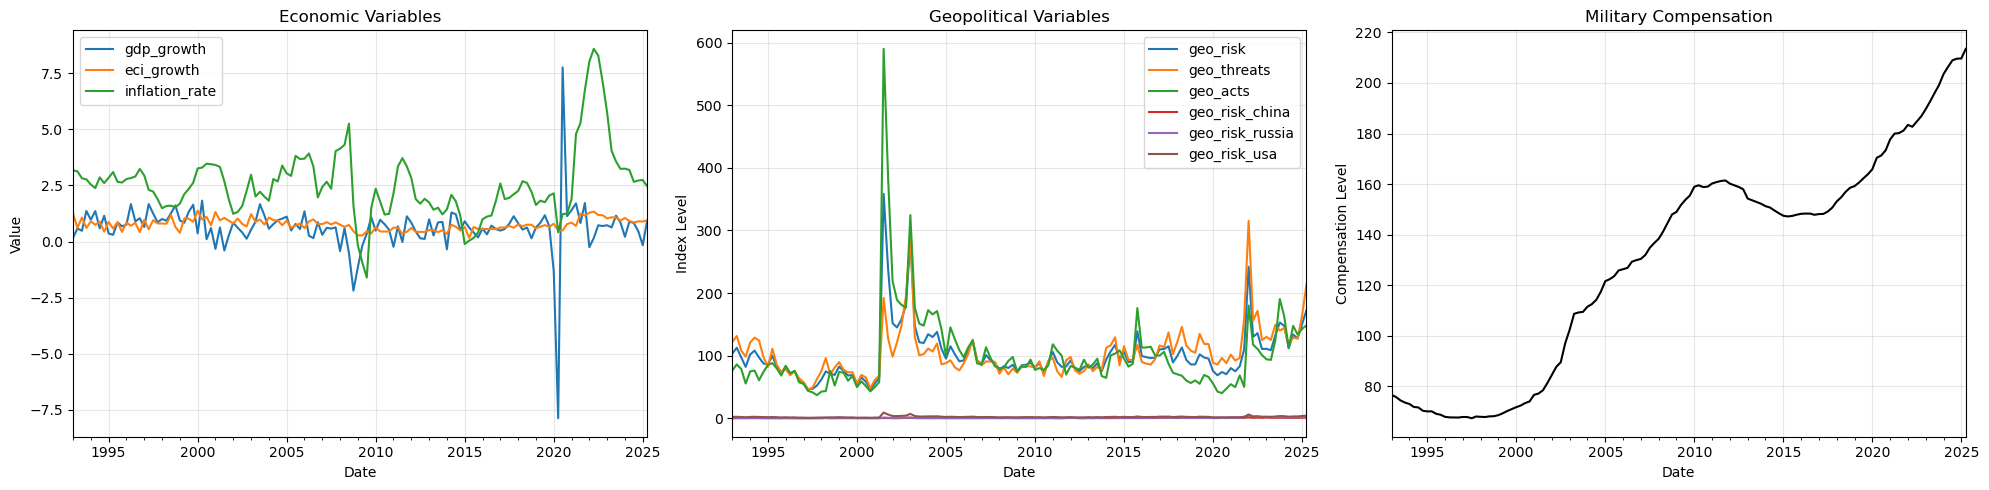

In [32]:

geo_df = geo_df.drop(columns=["military_comp"])




import matplotlib.pyplot as plt

# --- Data you already have ---
# econ_df: gdp_growth, eci_growth, inflation_rate
# geo_df: geo_risk, geo_threats, geo_acts, geo_risk_china, geo_risk_russia, geo_risk_usa
# usnational_qe["military_comp"]

plt.style.use("default")  # clean white background

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=False)

# -----------------------------------
# 1. Economic variables
# -----------------------------------
econ_df.plot(ax=axes[0])
axes[0].set_title("Economic Variables")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Value")
axes[0].grid(True, alpha=0.3)

# -----------------------------------
# 2. Geopolitical variables
# -----------------------------------
geo_df.plot(ax=axes[1])
axes[1].set_title("Geopolitical Variables")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Index Level")
axes[1].grid(True, alpha=0.3)

# -----------------------------------
# 3. Target Variable
# -----------------------------------
usnational_qe["military_comp"].plot(ax=axes[2], color="black")
axes[2].set_title("Military Compensation")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Compensation Level")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()